In [1]:
import sys
from time import time
from itertools import product, permutations

from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.special import binom
from scipy.linalg import logm, eigh, expm
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import SpectralClustering
import plotly.express as px

from tnpy.operators import SpinOperators, FullHamiltonian
from tnpy.model import Model1D, TotalSz
from tnpy.model.utils import boundary_vectors, minors_if_no_penalty
from tnpy.exact_diagonalization import ExactDiagonalization

np.set_printoptions(suppress=True, threshold=sys.maxsize, linewidth=sys.maxsize)

## Heisenberg model with random field

In [2]:
class RandomHeisenberg(Model1D):
    def __init__(
        self,
        n: int,
        h: float,
        jt: float = 1,
        jz: float = 1,
        penalty: float = 0,
        s_target: int = 0,
        offset: float = 0,
        trial_id: str = None,
        seed: int = None,
    ):
        super().__init__(n)
        self._h = h
        self._jt = jt
        self._jz = jz
        self._penalty = penalty
        self._s_target = s_target
        self._offset = offset
        self._trial_id = trial_id
        self._seed = seed
        rng = np.random.RandomState(self.seed)
        self._random_sequence = rng.uniform(-self.h, self.h, size=self.n)

    @property
    def h(self) -> float:
        return self._h

    @property
    def jt(self) -> float:
        return self._jt

    @property
    def jz(self) -> float:
        return self._jz

    @property
    def penalty(self) -> float:
        return self._penalty

    @property
    def s_target(self) -> int:
        return self._s_target

    @property
    def offset(self) -> float:
        return self._offset

    @offset.setter
    def offset(self, offset: float):
        self._offset = offset

    @property
    def trial_id(self) -> str:
        return self._trial_id

    @boundary_vectors(row=0, col=-1)
    @minors_if_no_penalty(row=3, col=3)
    def _elem(self, site: int) -> np.ndarray:
        Sp, Sm, Sz, I2, O2 = SpinOperators()

        alpha = (
            self.penalty * (0.25 + self.s_target**2 / self.n) - self.offset / self.n
        )
        beta = self._random_sequence[site] - 2.0 * self.penalty * self.s_target

        return np.array(
            [
                [
                    I2,
                    0.5 * self.jt * Sp,
                    0.5 * self.jt * Sm,
                    2.0 * self.penalty * Sz,
                    self.jz * Sz,
                    alpha * I2 + beta * Sz,
                ],
                [O2, O2, O2, O2, O2, Sm],
                [O2, O2, O2, O2, O2, Sp],
                [O2, O2, O2, I2, O2, Sz],
                [O2, O2, O2, O2, O2, Sz],
                [O2, O2, O2, O2, O2, I2],
            ],
            dtype=float,
        )

    @property
    def seed(self) -> int:
        return self._seed

    @seed.setter
    def seed(self, seed: int) -> None:
        self._seed = seed
        rng = np.random.RandomState(self.seed)
        self._random_sequence = rng.uniform(-self.h, self.h, size=self.n)

## Exact diagonalization

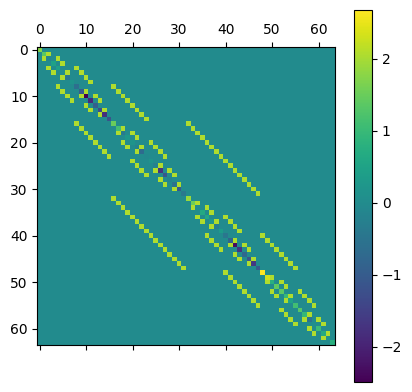

In [109]:
system_size = 6
model = RandomHeisenberg(n=system_size, jt=4.1, jz=1, h=2.026, seed=int(time()))
ed = ExactDiagonalization(model.mpo)

plt.matshow(ed.matrix)
plt.colorbar()

## Bipartite entanglement entropy

In [ ]:
entropy = np.array(
            [
                ed.entanglement_entropy(ed.n_sites // 2, level_idx)
                for level_idx in range(len(ed.matrix))
            ]
        )

print(entropy)

## Spin sector

In [ ]:
_total_sz = FullHamiltonian(TotalSz(model.n).mpo).matrix
spin_sector = np.diag(ed.evecs.T @ _total_sz @ ed.evecs)

print(spin_sector)

## The standard Rayleigh-Ritz procedure

projecting into S^z = 0 sector

In [4]:
u = np.array([[1, 0]])
d = np.array([[0, 1]])

def kron_product(ls):
    if not ls:
        return 1

    return np.kron(ls[0], kron_product(ls[1:]))

In [110]:
spin_zero_sequence = "{}{}".format("u" * (model.n // 2), "d" * (model.n // 2))
spin_zero_permutations = sorted(set(list(permutations(spin_zero_sequence, model.n))))
spin_map = {
    "u": u,
    "d": d
}

zero_charge_basis = [kron_product(list(map(spin_map.get, elem))) for elem in spin_zero_permutations]
proj = np.hstack(tuple(map(np.transpose, zero_charge_basis)))

In [111]:
reduced_mat = proj.T @ ed.matrix @ proj
evals, evecs = np.linalg.eigh(reduced_mat)

print(evals, "\n")
# print(proj @ evecs, "\n")

[-7.99534891 -6.15427483 -4.23962954 -4.16591818 -3.22642345 -2.57124077 -2.32043229 -1.1951596  -0.67253523 -0.62868815  0.3033022   0.49134378  1.10798761  1.84962914  2.14773125  2.71440701  3.56696442  3.85668969  5.41528595  6.71630992] 



In [ ]:
print([np.linalg.norm((ed.matrix - eval * np.eye(2 ** model.n)) @ proj @ evecs[:, idx]) for idx, eval in enumerate(evals)], "\n")
print(ed.evals, "\n")
print(ed.evecs, "\n")

[ 9.90457577 -0.5         0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.5        11.40457577]


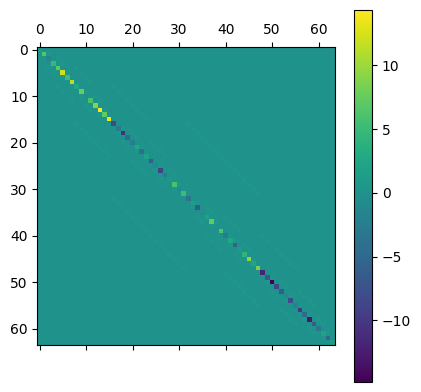

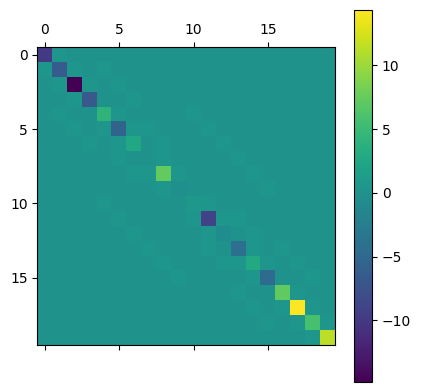

In [15]:
print(np.sum(np.diff(reduced_mat, axis=0), axis=0))

plt.matshow(ed.matrix)
plt.colorbar()
plt.matshow(reduced_mat)
plt.colorbar()

## Spectral clustering

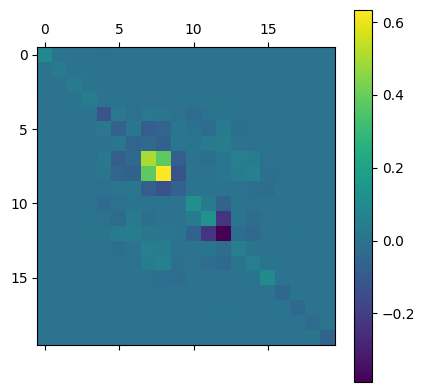

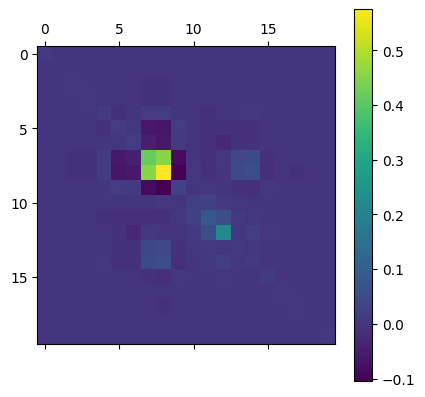

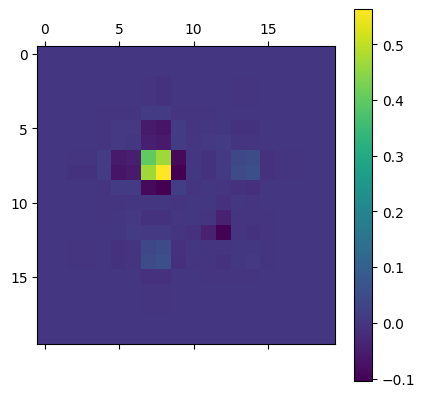

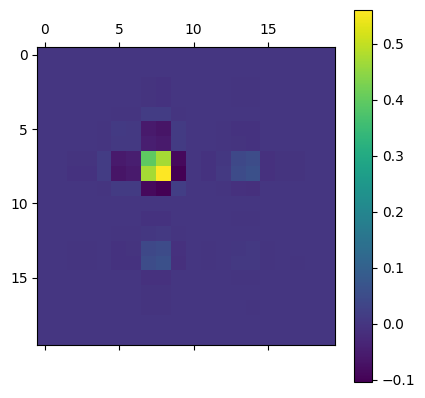

In [53]:
# diag = np.diagonal(reduced_mat)
# off_diag = reduced_mat - np.diagflat(diag)
# affinity = np.nan_to_num(np.reciprocal(np.abs(diag[:, None] * diag)) * np.square(off_diag))
# affinity = np.nan_to_num(np.exp(- np.reciprocal(off_diag) * np.abs(diag[:, None] - diag)))
opt = 0 * np.eye(len(reduced_mat)) - reduced_mat
affinity = np.linalg.inv(opt)
# affinity = reduced_mat
affinity_evals, affinity_evecs = np.linalg.eigh(affinity)
# opt *= np.max(np.abs(affinity_evals))
affinity /= np.max(np.abs(affinity_evals))
# affinity = np.square(affinity)

# diag = np.diagonal(reduced_mat)
# off_diag = reduced_mat - np.diagflat(diag)
# affinity = np.where(np.abs(off_diag) > 1e-12, 1, 0)
# factor = np.sqrt(np.diagflat(np.reciprocal(np.abs(evals[0] - diag))))
# affinity = factor @ affinity @ factor

plt.matshow(affinity)
plt.colorbar()
plt.matshow(np.linalg.matrix_power(affinity, 2))
plt.colorbar()
plt.matshow(np.linalg.matrix_power(affinity, 3))
plt.colorbar()
plt.matshow(np.linalg.matrix_power(affinity, 10))
plt.colorbar()

In [54]:
px.histogram(np.abs(affinity.ravel()))

matrix power 20


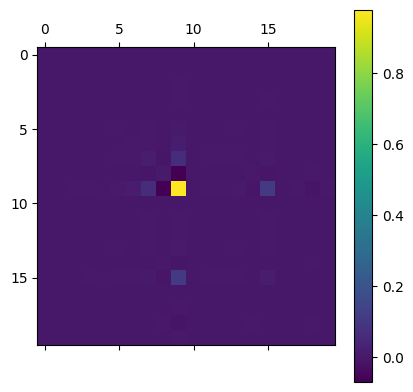

In [17]:
from IPython.display import clear_output
from time import sleep


for i in range(20):
    print(f"matrix power {i+1}")
    walker = np.linalg.matrix_power(affinity, i+1)
    plt.matshow(walker, animated=True)
    plt.colorbar()
    plt.show()
    sleep(1.0)
    clear_output(wait=True)

z = 14.43455082170634


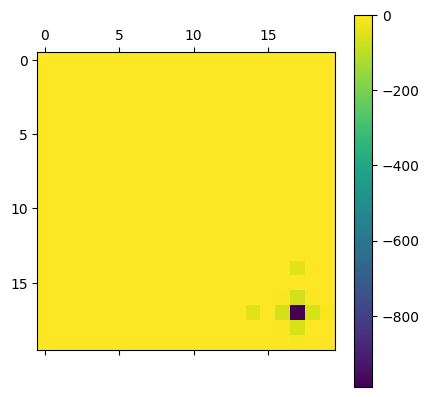

In [18]:
cutoff = 1e-3

for z in np.linspace(evals[0] + cutoff, evals[-1] - cutoff, 30):
    print(f"z = {z}")
    opt = z * np.eye(len(reduced_mat)) - reduced_mat
    affinity = np.linalg.inv(opt)
    plt.matshow(affinity, animated=True)
    plt.colorbar()
    plt.show()
    sleep(1.0)
    clear_output(wait=True)

In [ ]:
a = np.array(
    [[0.5, 0.25, 0.25],
    [0, 0.5, 0.5],
    [1, 0, 0]]
)

plt.matshow(a)
plt.colorbar()
plt.matshow(np.linalg.matrix_power(a, 2))
plt.colorbar()
plt.matshow(np.linalg.matrix_power(a, 3))
plt.colorbar()

In [ ]:
print(np.linalg.norm(reduced_mat))

evolution = expm(-0.001 * reduced_mat)
plt.matshow(evolution)
plt.colorbar()

evolution = expm(-0.002 * reduced_mat)
plt.matshow(evolution)
plt.colorbar()

plt.matshow(np.linalg.matrix_power(evolution, 2))
plt.colorbar()

[[0.         0.9849486  0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.9849486  0.         0.75892496 0.         0.35692419 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.75892496 0.         0.4818774  0.         0.2191417  0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.4818774  0.         0.         0.         0.2191417  0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.35692419 0.         0.         0.         0.46595918 0.         0.         0.         0.     

/var/folders/9z/xvqzg2q52gd8hxzhj2vgzrpm0000gn/T/ipykernel_1430/1379382634.py:3: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/9z/xvqzg2q52gd8hxzhj2vgzrpm0000gn/T/ipykernel_1430/1379382634.py:3: RuntimeWarning:

invalid value encountered in true_divide

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning:

normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



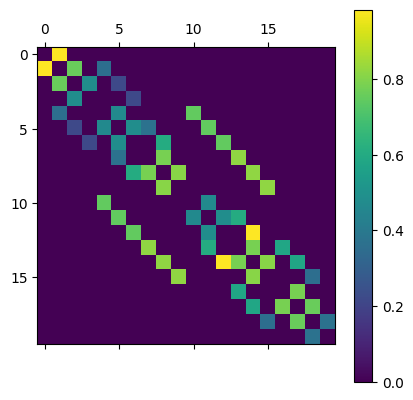

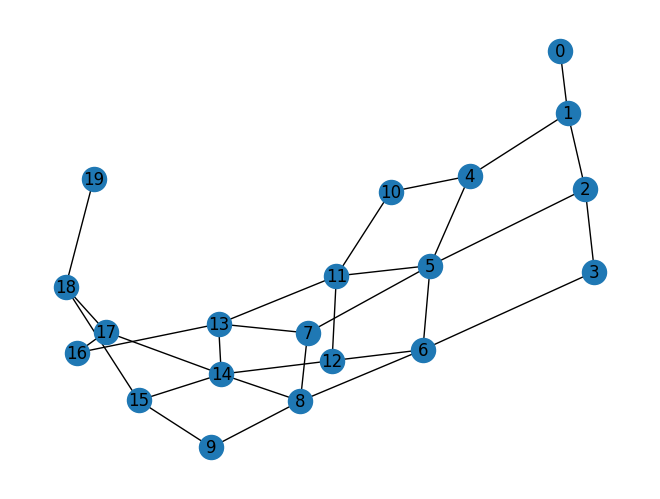

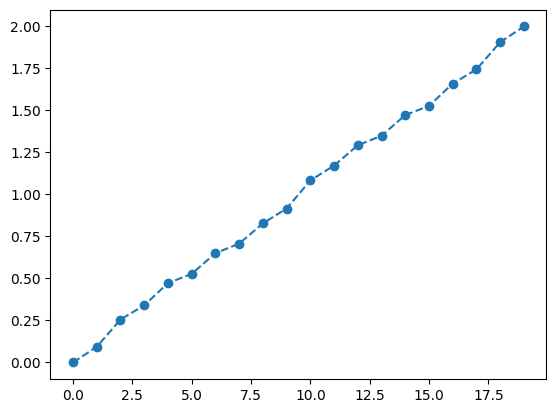

In [128]:
diag = np.diagonal(reduced_mat)
off_diag = reduced_mat - np.diagflat(diag)
affinity = np.nan_to_num(np.abs(diag[:, None] - diag) / off_diag)
affinity = np.exp(-1 * affinity)
np.fill_diagonal(affinity, 0)
# affinity = np.where(affinity > 1, 1, 0)

plt.matshow(affinity)
plt.colorbar()

graph = nx.from_numpy_array(affinity)
plt.figure()
nx.draw(graph, with_labels=True)

# degree_mat = np.diagflat(np.sum(affinity, axis=0))
# laplacian = degree_mat - affinity
# normalized_factor = np.diagflat(np.reciprocal(np.sqrt(np.diag(degree_mat))))
# laplacian = np.eye(len(affinity)) - normalized_factor @ affinity @ normalized_factor
# lap_evals, lap_evecs = np.linalg.eigh(laplacian)

lap_evals = nx.normalized_laplacian_spectrum(graph)

# print(degree_mat, "\n")
# print(normalized_factor)
# print(laplacian, "\n")
print(lap_evals, "\n")
# print(lap_evecs, "\n")
plt.figure()
plt.plot(lap_evals, marker='o', linestyle='dashed')

# Kirchhoff’s matrix-tree theorem
# print(1/len(lap_evals) * np.prod(lap_evals[1:]))

In [ ]:
plt.matshow(reduced_mat)
plt.colorbar()
plt.matshow(affinity)
plt.colorbar()
plt.matshow(laplacian)
plt.colorbar()
plt.matshow(lap_evecs)
plt.colorbar()

In [ ]:
evals, evecs = np.linalg.eigh(reduced_mat)
affinity_evals, affinity_evecs = np.linalg.eigh(affinity)

print(evals, "\n")
print(evecs, "\n")
print(affinity_evals, "\n")
print(affinity_evecs, "\n")

In [ ]:
graph = nx.from_numpy_array(np.square(affinity))

plt.matshow(reduced_mat)
plt.colorbar()
plt.matshow(nx.adjacency_matrix(graph).toarray())
plt.colorbar()
plt.matshow(nx.normalized_laplacian_matrix(graph).toarray())
plt.colorbar()

lap_evals = nx.normalized_laplacian_spectrum(graph)
print(lap_evals)
plt.figure()
plt.plot(lap_evals, marker='o', linestyle='dashed')

## Graph with NetworkX

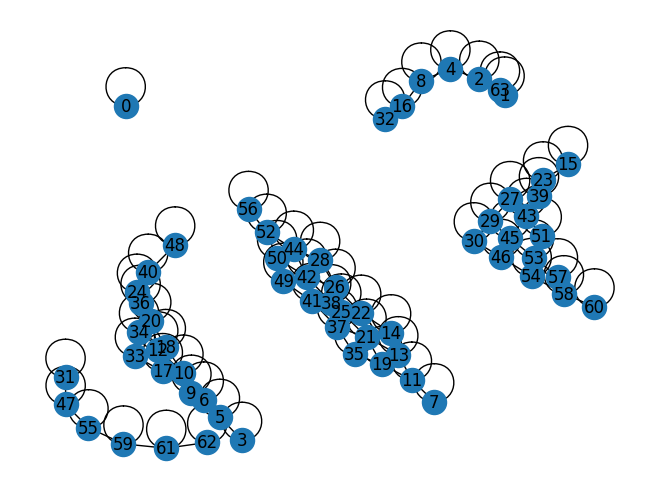

In [12]:
full_ham_graph = nx.from_numpy_array(ed.matrix)
nx.draw(full_ham_graph, with_labels=True)
# print(nx.clustering(full_ham_graph))

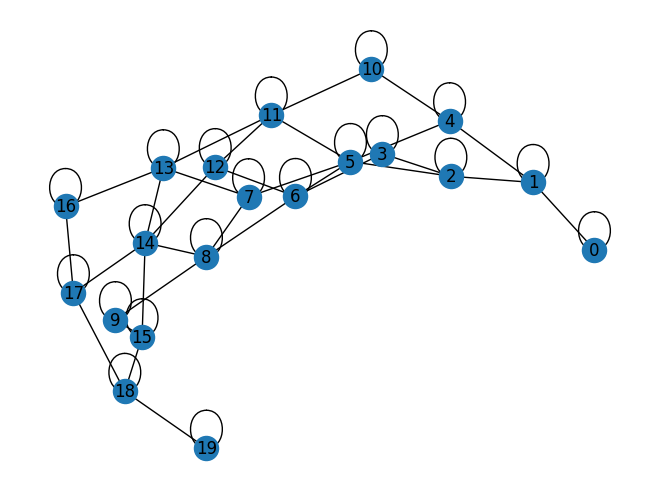

In [19]:
ham_graph = nx.from_numpy_array(reduced_mat)
nx.draw(ham_graph, with_labels=True)

# pos = nx.spring_layout(ham_graph)
# nx.draw_networkx_edge_labels(
#     ham_graph,
#     pos,
#     edge_labels={e: round(ham_graph.edges[e]['weight'], 2) for e in ham_graph.edges}
# )
# nx.draw_networkx_nodes(ham_graph, pos, alpha=0.1)
# nx.draw_networkx_edges(ham_graph, pos)

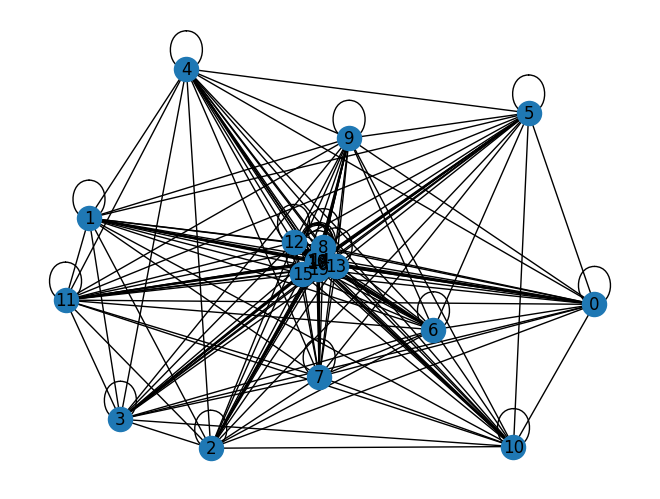

In [20]:
graph = nx.from_numpy_array(np.square(affinity))
nx.draw(graph, with_labels=True)

# pos = nx.spring_layout(graph)
# nx.draw_networkx_edge_labels(
#     graph,
#     pos,
#     edge_labels={e: round(graph.edges[e]['weight'], 2) for e in graph.edges}
# )
# nx.draw_networkx_nodes(graph, pos, alpha=0.1)
# nx.draw_networkx_edges(graph, pos)

In [ ]:
graph = nx.from_numpy_array(np.linalg.matrix_power(affinity, 10))
nx.draw(graph, with_labels=True)

In [ ]:
nx.draw_spectral(graph, with_labels=True)

In [ ]:
clustering = SpectralClustering(
    n_clusters=2,
    affinity="precomputed",
    assign_labels="discretize"
).fit(np.square(affinity))

clustering.labels_

## Spectral gap of Laplacian matrix

In [135]:
def projector(n):
    spin_zero_sequence = "{}{}".format("u" * (n // 2), "d" * (n // 2))
    spin_zero_permutations = sorted(set(list(permutations(spin_zero_sequence, int(n)))))
    spin_map = {
        "u": u,
        "d": d
    }

    zero_charge_basis = [kron_product(list(map(spin_map.get, elem))) for elem in spin_zero_permutations]
    return np.hstack(tuple(map(np.transpose, zero_charge_basis)))


def laplacian_evals(mat):
    diag = np.diagonal(mat)
    off_diag = mat - np.diagflat(diag)
    affinity = np.nan_to_num(off_diag / np.abs(diag[:, None] - diag))
    affinity = np.where(affinity > 1, 1, 0)
    # affinity = np.square(np.linalg.inv(0 * np.eye(len(mat)) - mat))

    # degree_mat = np.diagflat(np.sum(affinity, axis=0))
    # laplacian = degree_mat - affinity
    # normalized_factor = np.diagflat(np.reciprocal(np.sqrt(np.diag(degree_mat))))
    # normalized_factor[normalized_factor == np.inf] = 0
    # laplacian = np.eye(len(affinity)) - normalized_factor @ affinity @ normalized_factor
    # lap_evals, lap_evecs = np.linalg.eigh(laplacian)
    graph = nx.from_numpy_array(affinity)
    return nx.normalized_laplacian_spectrum(graph)


round_off_error = 1e-12

ns = np.arange(4, 12, 2, dtype=int)
hs = np.linspace(0, 5, 30)
seeds = np.arange(1000, 1010)
df = pd.DataFrame(columns=["n", "h", "seed", "n_zeros", "spectral_gap", "last_eval"])
for idx, (n, h, seed) in enumerate(tqdm(product(ns, hs, seeds))):
    model = RandomHeisenberg(n=n, jt=4.1, jz=1, h=h, seed=seed)
    proj = projector(n)
    reduced_mat = proj.T @ FullHamiltonian(model.mpo).matrix @ proj
    _lap_evals = laplacian_evals(reduced_mat)
    # asign = np.sign(_lap_evecs[:, 1])
    # signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    n_zeros = len(_lap_evals[_lap_evals < round_off_error])
    spectral_gap = _lap_evals[n_zeros] if n_zeros < len(reduced_mat) else np.nan
    # spectral_gap = _lap_evals[n_zeros]
    df.loc[idx] = [
        n,
        h,
        seed,
        n_zeros,
        spectral_gap,
        # _lap_evals[_lap_evals > round_off_error][1],
        # np.sum(signchange),
        _lap_evals[-1],
        # 1/len(_lap_evals) * np.prod(_lap_evals[n_zeros:])
    ]

0it [00:00, ?it/s]/var/folders/9z/xvqzg2q52gd8hxzhj2vgzrpm0000gn/T/ipykernel_1430/364404550.py:16: RuntimeWarning:

invalid value encountered in true_divide

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning:

normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

/var/folders/9z/xvqzg2q52gd8hxzhj2vgzrpm0000gn/T/ipykernel_1430/364404550.py:16: RuntimeWarning:

invalid value encountered in true_divide

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning:

normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

/var/folders/9z/xvqzg2q52gd8hxzhj2vgzrpm0000gn/T/ipykernel_1430/364404550.py:16: RuntimeWarning:

invalid value encountered in true_divide

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning:

normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

/var/folders/9z/xvqzg2q52gd8hxzhj2

In [137]:
# df["renorm_spectral_gap"] = df["spectral_gap"] * df["diameter"]
# df["renorm_last_eval"] = df["last_eval"] * df["diameter"]
df = df.groupby(["n", "h"], as_index=False).mean()

fig = px.line(df, x="h", y="n_zeros", color="n", markers=True, log_y=True)
fig.show()
fig = px.line(df, x="h", y="spectral_gap", color="n", markers=True, log_y=True)
fig.show()
# fig = px.line(df, x="h", y="renorm_spectral_gap", color="n", markers=True)
# fig.show()
fig = px.line(df, x="h", y="last_eval", color="n", markers=True)
fig.show()
# fig = px.line(df, x="h", y="renorm_last_eval", color="n", markers=True)
# fig.show()
# fig = px.line(df, x="h", y="n_spanning_tree", color="n", markers=True, log_y=True)
# fig.show()

**Note**: the Laplacian gap corresponding to h = 0 seems to be the Golden angle ??

### Test gap ratio

In [ ]:
def gap_ratio(evals):
    gap = np.diff(evals)
    next_gap = np.roll(gap, -1)
    return np.minimum(gap / next_gap, next_gap / gap)

df2 = pd.DataFrame(columns=["h", "seed", "gap_ratio"])
for idx, (h, seed) in enumerate(product(hs, seeds)):
    model = RandomHeisenberg(n=system_size, jt=1, jz=1, h=h, seed=seed)
    reduced_mat = proj.T @ FullHamiltonian(model.mpo).matrix @ proj
    evals, evecs = np.linalg.eigh(reduced_mat)
    df2.loc[idx] = [
        h,
        seed,
        np.mean(gap_ratio(evals))
    ]

df2 = df2.groupby(["h"], as_index=False).mean()
fig = px.line(df2, x="h", y="gap_ratio", markers=True)
fig.show()

### Test numpy random state

In [44]:
rng = np.random.RandomState(seed=2000)
print(rng.uniform(-1, 1, size=4))

rng = np.random.RandomState(seed=2000)
print(rng.uniform(-2, 2, size=4))

[ 0.14103457  0.12905751 -0.02311633 -0.32704449]
[ 0.28206914  0.25811502 -0.04623267 -0.65408899]


## Harmonic Rayleigh-Ritz

In [ ]:
zero_charge_basis = [
    [u, u, d, d],
    [u, d, u, d],
    [u, d, d, u],
    [d, u, u, d],
    [d, u, d, u],
    [d, d, u, u]
]

proj = np.hstack(tuple(map(np.transpose, tuple(map(kron_product, zero_charge_basis)))))

shift = 16
shifted_mat = ed.matrix - shift * np.eye(len(ed.matrix))
evals, evecs = eigh(a=proj.T @ shifted_mat @ proj, b=proj.T @ np.linalg.matrix_power(shifted_mat, 2) @ proj)

evals = shift + np.reciprocal(evals)
evecs = shifted_mat @ proj @ evecs
residual_vec = np.stack([(ed.matrix - eval * np.eye(len(ed.matrix))) @ evecs[:, idx] for idx, eval in enumerate(evals)], axis=1)

print(evals, "\n")
print(evecs, "\n")
print(residual_vec, "\n")
print(np.linalg.norm(residual_vec, axis=0), "\n")

## Test against transverse Ising model

In [45]:
class TransverseIsing(Model1D):
    def __init__(self, n, j, h):
        r"""

        .. math::

            H = -j \left( \sum_{i=0}^{N-1} S_{i+1}^z S_i^z + h S_i^x \right)

        Args:
            n: System size.
            j: Overall prefactor of energy.
            h: The coupling strength of transversed field.
        """
        super().__init__(n)
        self._j = j
        self._h = h

    @property
    def j(self):
        return self._j

    @property
    def h(self):
        return self._h

    @boundary_vectors(row=0, col=-1)
    def _elem(self, site: int) -> np.ndarray:
        Sp, Sm, Sz, I2, O2 = SpinOperators()
        Sx = Sp + Sm
        return np.array(
            [
                [I2, -self.j * Sz, -self.j * self.h * Sx],
                [O2, O2, Sz],
                [O2, O2, I2]
            ],
            dtype=float,
        )

[-0.81603746 -0.80526278 -0.41214893 -0.40137425 -0.26077468 -0.25       -0.15388853 -0.14311385  0.14311385  0.15388853  0.25        0.26077468  0.40137425  0.41214893  0.80526278  0.81603746] 



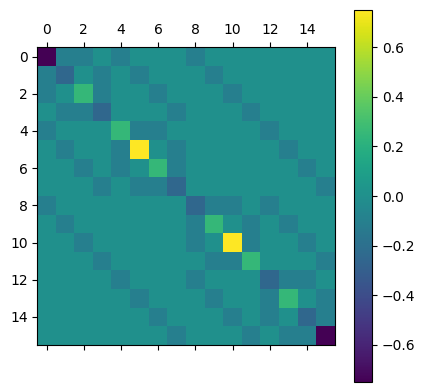

In [87]:
model = TransverseIsing(n=4, j=1, h=0.1)
ed = ExactDiagonalization(model.mpo)

print(ed.evals, "\n")
# print(ed.evecs , "\n")

plt.matshow(ed.matrix)
plt.colorbar()

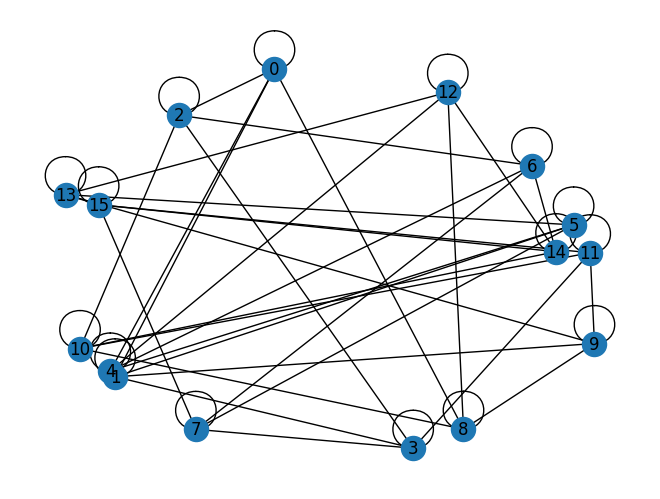

In [88]:
graph = nx.from_numpy_array(ed.matrix)
nx.draw(graph, with_labels=True)

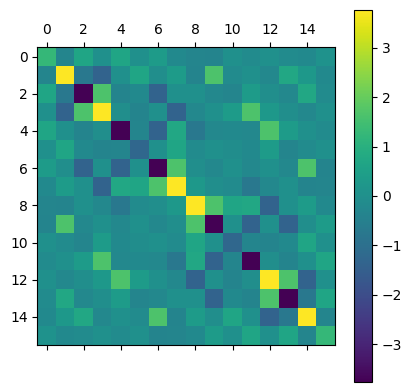

In [89]:
# diag = np.diagonal(ed.matrix)
# affinity = np.reciprocal(ed.matrix)
# affinity[affinity == np.inf] = 0
# np.fill_diagonal(affinity, 0)
affinity = np.linalg.inv(0 * np.eye(len(ed.matrix)) - ed.matrix)

plt.matshow(affinity)
plt.colorbar()

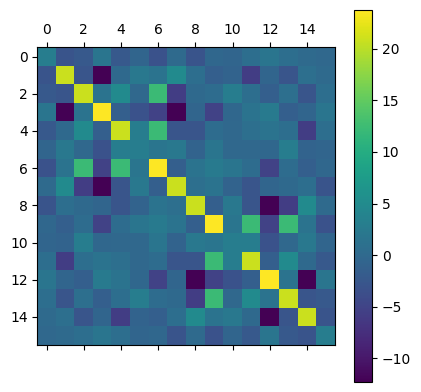

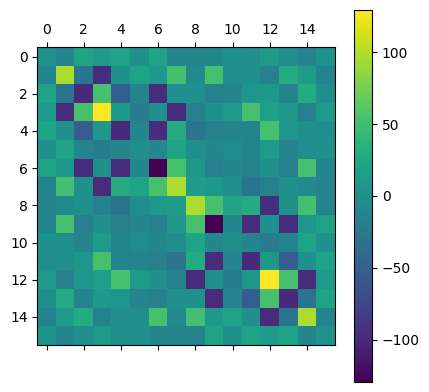

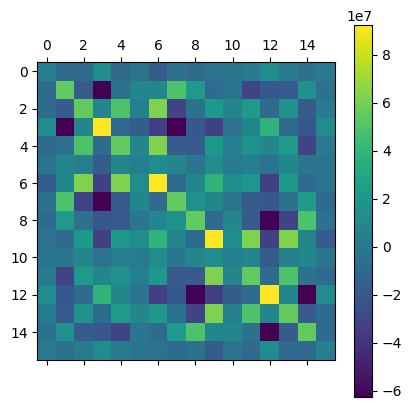

In [90]:
plt.matshow(np.linalg.matrix_power(affinity, 2))
plt.colorbar()
plt.matshow(np.linalg.matrix_power(affinity, 3))
plt.colorbar()
plt.matshow(np.linalg.matrix_power(affinity, 10))
plt.colorbar()

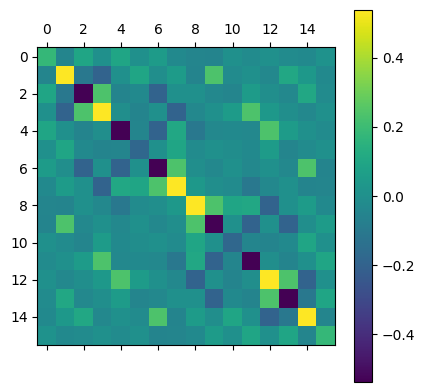

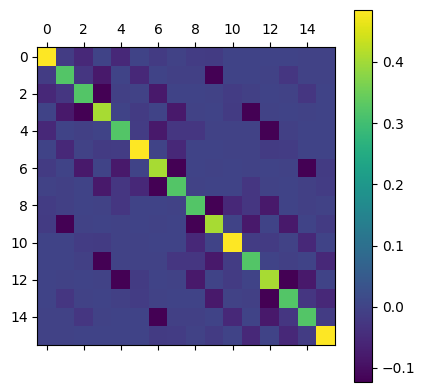

In [91]:
# diag = np.diagonal(ed.matrix)
# off_diag = ed.matrix - np.diagflat(diag)
# affinity = np.abs(off_diag) * np.reciprocal(np.abs(diag[:, None] - diag))
# affinity[np.nonzero(off_diag)] *= model.h
# affinity[np.where(off_diag == 0)] = 0
affinity = np.linalg.inv(0 * np.eye(len(ed.matrix)) - ed.matrix)
affinity_evals, affinity_evecs = np.linalg.eigh(affinity)
affinity /= np.max(np.abs(affinity_evals))

# affinity = np.abs(np.linalg.inv(ed.matrix))
# affinity[affinity == np.inf] = 0
# affinity[affinity == -np.inf] = 0
# affinity = np.nan_to_num(affinity)
# np.fill_diagonal(affinity, 0)
# print(affinity)

degree_mat = np.diagflat(np.sum(np.square(affinity), axis=0))
# laplacian = degree_mat - affinity
normalized_factor = np.diagflat(np.reciprocal(np.sqrt(np.diag(degree_mat))))
laplacian = np.eye(len(affinity)) - normalized_factor @ np.square(affinity) @ normalized_factor
lap_evals, lap_evecs = np.linalg.eigh(laplacian)

plt.matshow(affinity)
plt.colorbar()
plt.matshow(laplacian)
plt.colorbar()

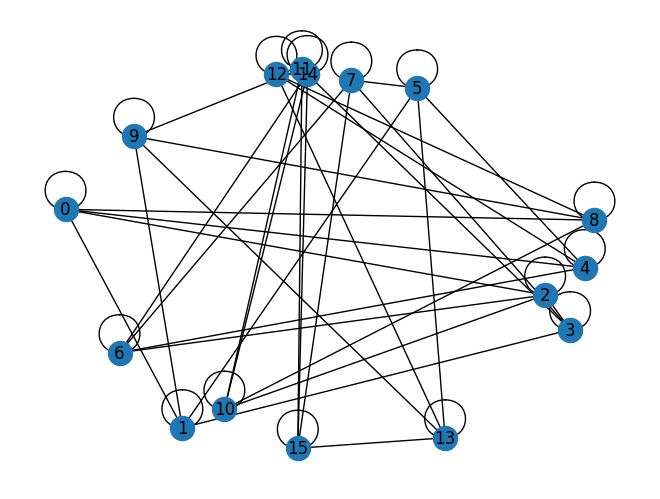

In [93]:
graph = nx.from_numpy_array(ed.matrix)
nx.draw(graph, with_labels=True)

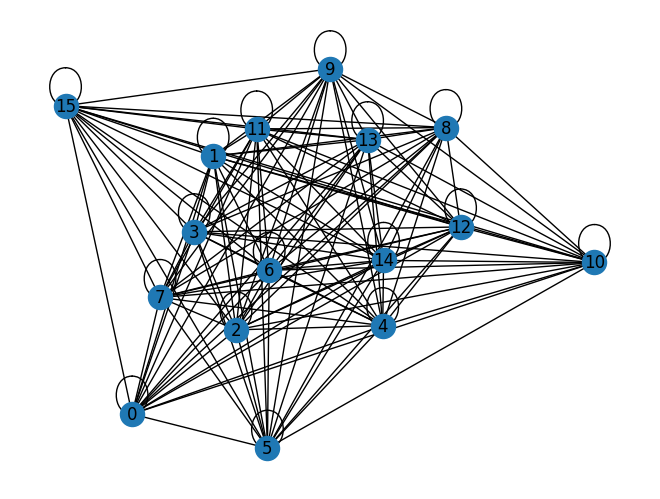

In [92]:
graph = nx.from_numpy_array(np.square(affinity))
nx.draw(graph, with_labels=True)

In [ ]:
print(ed.evals, "\n")
print(ed.evecs, "\n")
print(lap_evals, "\n")
print(lap_evecs, "\n")

In [95]:
ns = np.arange(4, 12, 2, dtype=int)
hs = np.linspace(-2, 2, 80)

df = pd.DataFrame(columns=["n", "h", "spectral_gap", "last_eval", "diameter"])
for idx, (n, h) in enumerate(tqdm(product(ns, hs))):
    model = TransverseIsing(n=n, j=1, h=h)
    ed = ExactDiagonalization(model.mpo)
    
    affinity = np.linalg.inv(0 * np.eye(len(ed.matrix)) - ed.matrix)
    affinity_evals, affinity_evecs = np.linalg.eigh(affinity)
    affinity /= np.max(np.abs(affinity_evals))

    degree_mat = np.diagflat(np.sum(np.abs(affinity), axis=0))
    normalized_factor = np.diagflat(np.reciprocal(np.sqrt(np.diag(degree_mat))))
    laplacian = np.eye(len(affinity)) - normalized_factor @ affinity @ normalized_factor
    lap_evals, lap_evecs = np.linalg.eigh(laplacian)
    df.loc[idx] = [
        n,
        h,
        lap_evals[1],
        lap_evals[-1],
        nx.diameter(nx.from_numpy_array(affinity))
    ]

320it [03:50,  1.39it/s] 


In [96]:
df["renorm_spectral_gap"] = df["spectral_gap"] * df["diameter"]

fig = px.line(df, x="h", y="spectral_gap", color="n", markers=True)
fig.show()
fig = px.line(df, x="h", y="renorm_spectral_gap", color="n", markers=True)
fig.show()
fig = px.line(df, x="h", y="last_eval", color="n", markers=True)
fig.show()